# Proyecto de regresión

## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    QuantileTransformer
)
from sklearn.metrics import r2_score

## Funciones auxiliares

In [2]:
def train_models(x_train, y_train, model_list) -> dict:
    CV = 5
    
    trained_model_dict = {}
    
    for model_class, model_params in model_list:
        
        gs_estimator = GridSearchCV(
            estimator = model_class(),
            param_grid = model_params,
            cv = CV
        )
        gs_estimator.fit(x_train, y_train)
        
        best_params = gs_estimator.best_params_
        print(f'[{model_class.__name__:^25}]: {gs_estimator.best_params_}')
        model = model_class(**best_params)

        start_time = time.time()
        model.fit(x_train, y_train)
        training_time = time.time() - start_time

        trained_model_dict[model_class.__name__] = {
            'model':            model,
            'training_time':    training_time
        }
    
    return trained_model_dict

In [3]:
def predict_models(x_test, y_test, trained_model_dict) -> dict:
    tested_model_dict = {}

    for model_name, model_details in trained_model_dict.items():
        start_time = time.time()
        predicted = model_details['model'].predict(x_test)
        predict_time = time.time() - start_time

        tested_model_dict[model_name] = {
            'prediction_time':      predict_time,
            'prediction':           predicted,
            'r2_score':             r2_score(y_test, predicted)
        }
    
    return tested_model_dict

In [4]:
def results_to_dataframe(trained_model_dict, tested_model_dict) -> pd.DataFrame:
    name_list =     [name for name in trained_model_dict]
    tr_time_list =  [elem.get('training_time') for elem in trained_model_dict.values()]
    pr_time_list =  [elem.get('prediction_time') for elem in tested_model_dict.values()]
    r2_list =       [elem.get('r2_score') for elem in tested_model_dict.values()]
    
    return pd.DataFrame({
        'Model': name_list,
        'R2 score': r2_list,
        'Training time': tr_time_list,
        'Prediction time': pr_time_list,
    }).sort_values(by='R2 score', ascending=True)

In [5]:
def plot_results(tested_model_dict, y_test, filename = None):
    n_cols = len(tested_model_dict)

    fig, ax = plt.subplots(ncols=n_cols, figsize=(20, 3), gridspec_kw={'wspace': 0.5})

    for i, model_name in enumerate(tested_model_dict):
        
        predicted = tested_model_dict[model_name].get('prediction')

        ax[i].set_title(model_name, fontsize = 15)
        ax[i].scatter(x = predicted, y = y_test)
        ax[i].set_xlabel('Predicho', fontsize = 13)
        ax[i].set_ylabel('Real', fontsize = 13)

        upper_limit = max(
            max(predicted),
            max(y_test)
        ) * 1.1
        ax[i].set_xlim([0, upper_limit])
        ax[i].set_ylim([0, upper_limit])

        ax[i].plot(
            ax[i].get_xlim(),
            ax[i].get_ylim(),
            ls='--',
            c='r'
        )

    if filename:
        fig.savefig(filename, format='eps', bbox_inches = 'tight', pad_inches=0.25)

In [6]:
import winsound
import time

def alert_user():
    winsound.Beep(1750, 125)
    time.sleep(0.125)
    winsound.Beep(1750, 125)
    time.sleep(1)
    winsound.Beep(1750, 125)
    time.sleep(0.125)
    winsound.Beep(1750, 125)

## Lectura de ficheros

In [7]:
df = pd.read_csv('../data/input/train_2_pr.csv')

display(df)

,Unnamed: 0,shipment_id,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,selected,shipping_time
0,0,S000720,2019-06-08 07:17:51,A,Y,GB,IN,88.61000,355.00,0.7500,Air,SC3,Y,5.00741
1,1,S000725,2019-07-12 15:23:21,A,Y,GB,IN,85.65000,105.00,0.9000,Ocean,SC1,Y,21.41215
2,2,S000736,2019-10-04 14:23:29,A,Y,GB,IN,86.22000,100.00,0.7500,Air,SC3,Y,5.33692
3,3,S000738,2020-01-07 09:19:50,A,Y,GB,IN,94.43000,1071.00,1.0500,Air,SC2,Y,5.14792
4,4,S000739,2020-04-11 06:36:03,A,Y,GB,IN,94.24000,2007.00,0.7500,Air,SC3,Y,5.03067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,5109,S7631147,2020-03-31 10:32:09,A,X,GB,BD,104.86000,304.00,1.1250,Ocean,SC1,Y,15.26933
5110,5110,S9671147,2020-04-05 16:36:06,A,X,GB,BD,103.56125,240.00,0.5625,Ocean,SC2,Y,12.41192
5111,5111,S1407148,2020-04-09 10:59:51,A,X,GB,BD,105.55000,400.00,1.1250,Ocean,SC1,Y,5.68333
5112,5112,S7478148,2020-04-24 15:27:00,A,X,GB,BD,105.95000,398.00,1.1250,Ocean,SC1,Y,41.97199


## Limpieza base de los datos

In [8]:
df.drop(
    columns = [
        'Unnamed: 0',       # Índice sin uso
        'shipment_id',      # ID aleatorio sin significancia
        'pick_up_point',    # Toma un único valor
        'drop_off_point',   # Toma un único valor
        'selected'          # Toma un único valor
    ],
    inplace = True
)

display(df)

,send_timestamp,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time
0,2019-06-08 07:17:51,GB,IN,88.61000,355.00,0.7500,Air,SC3,5.00741
1,2019-07-12 15:23:21,GB,IN,85.65000,105.00,0.9000,Ocean,SC1,21.41215
2,2019-10-04 14:23:29,GB,IN,86.22000,100.00,0.7500,Air,SC3,5.33692
3,2020-01-07 09:19:50,GB,IN,94.43000,1071.00,1.0500,Air,SC2,5.14792
4,2020-04-11 06:36:03,GB,IN,94.24000,2007.00,0.7500,Air,SC3,5.03067
...,...,...,...,...,...,...,...,...,...
5109,2020-03-31 10:32:09,GB,BD,104.86000,304.00,1.1250,Ocean,SC1,15.26933
5110,2020-04-05 16:36:06,GB,BD,103.56125,240.00,0.5625,Ocean,SC2,12.41192
5111,2020-04-09 10:59:51,GB,BD,105.55000,400.00,1.1250,Ocean,SC1,5.68333
5112,2020-04-24 15:27:00,GB,BD,105.95000,398.00,1.1250,Ocean,SC1,41.97199


## Definición de modelos de regresión

In [9]:
model_list = [
    (SVR, {
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.1, 0.2, 0.5]
    }),
    (DecisionTreeRegressor, {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    (RandomForestRegressor, {}),
    (AdaBoostRegressor, {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'loss': ['linear', 'square', 'exponential'],
    }),
    (KNeighborsRegressor, {
        'n_neighbors': [5, 10, 20],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [30, 50, 100],
        'p': [1, 2]
    })
]

## Escenarios de regresión

### 01 - Etiquetado de características categóricas + timestamp a segundos

In [ ]:
df_01 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_01[col] = LabelEncoder().fit_transform(df_01[col])


# Conversión a segundos desde Epoch
df_01['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9


display(df_01)

In [ ]:
X = df_01.drop(columns=['shipping_time'])
y = df_01['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
train_results = train_models(X_train, y_train, model_list)

test_results = predict_models(X_test, y_test, train_results)

results = results_to_dataframe(train_results, test_results)

results.to_latex('../docs/tables/01_table.tex', index = False)

display(results)

In [ ]:
results.to_latex('../docs/tables/01_table.tex', index = False)

In [ ]:
plot_results(test_results, y_test, '../docs/01_graph.eps')

### 02 - Etiquetado de características + timestamp a segundos + normalizado por z_score

In [ ]:
df_02 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_02[col] = LabelEncoder().fit_transform(df_02[col])


# Conversión a segundos desde Epoch
df_02['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_02[col] = StandardScaler().fit_transform(df_02[[col]])[:,0]

display(df_02)

In [ ]:
X = df_02.drop(columns=['shipping_time'])
y = df_02['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
train_results = train_models(X_train, y_train, model_list)

test_results = predict_models(X_test, y_test, train_results)

results = results_to_dataframe(train_results, test_results)

results.to_latex('../docs/tables/02_table.tex', index = False)

display(results)

In [ ]:
plot_results(test_results, y_test, '../docs/02_graph.eps')

### 03 - Etiquetado + timestamp + MinMax scaling

In [ ]:
df_03 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_03[col] = LabelEncoder().fit_transform(df_03[col])


# Conversión a segundos desde Epoch
df_03['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_03[col] = MinMaxScaler().fit_transform(df_03[[col]])[:,0]

display(df_03)

In [ ]:
X = df_03.drop(columns=['shipping_time'])
y = df_03['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
train_results = train_models(X_train, y_train, model_list)

test_results = predict_models(X_test, y_test, train_results)

results = results_to_dataframe(train_results, test_results)

results.to_latex('../docs/tables/03_table.tex', index = False)

display(results)

In [ ]:
plot_results(test_results, y_test, '../docs/03_graph.eps')

### 04 - Etiquetado + timestamp + RobustScaller

In [ ]:
df_04 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_04[col] = LabelEncoder().fit_transform(df_04[col])


# Conversión a segundos desde Epoch
df_04['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_04[col] = RobustScaler().fit_transform(df_04[[col]])[:,0]

display(df_04)

In [ ]:
X = df_04.drop(columns=['shipping_time'])
y = df_04['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
train_results = train_models(X_train, y_train, model_list)

test_results = predict_models(X_test, y_test, train_results)

results = results_to_dataframe(train_results, test_results)

results.to_latex('../docs/tables/04_table.tex', index = False)

display(results)

In [ ]:
plot_results(test_results, y_test, '../docs/04_graph.eps')

### 05 - Etiquetado + timestamp + QuantileTransformer

In [ ]:
df_05 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_05[col] = LabelEncoder().fit_transform(df_05[col])


# Conversión a segundos desde Epoch
df_05['send_timestamp'] = pd.to_datetime(df['send_timestamp']).astype(np.int64) // 10**9

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_05[col] = QuantileTransformer().fit_transform(df_05[[col]])

display(df_05)

In [ ]:
X = df_05.drop(columns=['shipping_time'])
y = df_05['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
train_results = train_models(X_train, y_train, model_list)

test_results = predict_models(X_test, y_test, train_results)

results = results_to_dataframe(train_results, test_results)

results.to_latex('../docs/tables/05_table.tex', index = False)

display(results)

In [ ]:
plot_results(test_results, y_test, '../docs/05_graph.eps')

### 06 - Etiquetado + timestamp labeling

In [ ]:
df_06 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_06[col] = LabelEncoder().fit_transform(df_06[col])

# Conversión de tiempo a categorias
df_06['send_timestamp'] = pd.to_datetime(df_06['send_timestamp'])
df_06["year"] =         df_06["send_timestamp"].dt.year
df_06["month"] =        df_06["send_timestamp"].dt.month
df_06["day"] =          df_06["send_timestamp"].dt.day
df_06["dayofweek"] =    df_06["send_timestamp"].dt.day_of_week
df_06["dayofyear"] =    df_06["send_timestamp"].dt.day_of_year
df_06["hour"] =         df_06["send_timestamp"].dt.hour
df_06["minute"] =       df_06["send_timestamp"].dt.minute
df_06.drop(columns="send_timestamp", inplace=True)

display(df_06)

In [ ]:
X = df_06.drop(columns=['shipping_time'])
y = df_06['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
train_results = train_models(X_train, y_train, model_list)

test_results = predict_models(X_test, y_test, train_results)

results = results_to_dataframe(train_results, test_results)

results.to_latex('../docs/tables/06_table.tex', index = False)

display(results)

In [ ]:
plot_results(test_results, y_test, '../docs/06_graph.eps')

### 07 - etiquetado + timestamp labeling + quantile normalization

In [ ]:
df_07 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_07[col] = LabelEncoder().fit_transform(df_07[col])

# Conversión de tiempo a categorias
df_07['send_timestamp'] = pd.to_datetime(df_07['send_timestamp'])
df_07["year"] =         df_07["send_timestamp"].dt.year
df_07["month"] =        df_07["send_timestamp"].dt.month
df_07["day"] =          df_07["send_timestamp"].dt.day
df_07["dayofweek"] =    df_07["send_timestamp"].dt.day_of_week
df_07["dayofyear"] =    df_07["send_timestamp"].dt.day_of_year
df_07["hour"] =         df_07["send_timestamp"].dt.hour
df_07["minute"] =       df_07["send_timestamp"].dt.minute
df_07.drop(columns="send_timestamp", inplace=True)

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_07[col] = QuantileTransformer().fit_transform(df_07[[col]])

display(df_07)

In [ ]:
X = df_07.drop(columns=['shipping_time'])
y = df_07['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
train_results = train_models(X_train, y_train, model_list)

test_results = predict_models(X_test, y_test, train_results)

results = results_to_dataframe(train_results, test_results)

results.to_latex('../docs/tables/07_table.tex', index = False)

display(results)

In [ ]:
plot_results(test_results, y_test, '../docs/07_graph.eps')

### 08 - Etiquetado + timestamp labeling extrayendo minutos + quantile normalization

In [10]:
df_08 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_08[col] = LabelEncoder().fit_transform(df_08[col])

# Conversión de tiempo a categorias
df_08['send_timestamp'] = pd.to_datetime(df_08['send_timestamp'])
df_08["year"] =         df_08["send_timestamp"].dt.year
df_08["month"] =        df_08["send_timestamp"].dt.month
df_08["day"] =          df_08["send_timestamp"].dt.day
df_08["dayofweek"] =    df_08["send_timestamp"].dt.day_of_week
df_08["dayofyear"] =    df_08["send_timestamp"].dt.day_of_year
df_08["hour"] =         df_08["send_timestamp"].dt.hour
df_08["minute"] =       df_08["send_timestamp"].dt.minute
df_08.drop(columns="send_timestamp", inplace=True)

# Normalizado de variables numéricas por z_score
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_08[col] = QuantileTransformer().fit_transform(df_08[[col]])

display(df_08)

,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,shipping_time,year,month,day,dayofweek,dayofyear,hour,minute
0,0,1,0.311521,0.395896,0.201702,0,2,0.008233,2019,6,8,5,159,7,17
1,0,1,0.078579,0.081582,0.574074,1,0,0.789785,2019,7,12,4,193,15,23
2,0,1,0.121095,0.064565,0.201702,0,2,0.417803,2019,10,4,4,277,14,23
3,0,1,0.898880,0.741809,0.882883,0,1,0.184774,2020,1,7,1,7,9,19
4,0,1,0.890891,0.876376,0.201702,0,2,0.037231,2020,4,11,5,102,6,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,0,0,0.953476,0.340340,1.000000,1,0,0.694697,2020,3,31,1,91,10,32
5110,0,0,0.947864,0.273273,0.000000,1,1,0.654626,2020,4,5,6,96,16,36
5111,0,0,0.955619,0.421421,1.000000,1,0,0.526478,2020,4,9,3,100,10,59
5112,0,0,0.957694,0.416166,1.000000,1,0,0.989116,2020,4,24,4,115,15,27


In [11]:
X = df_08.drop(columns=['shipping_time'])
y = df_08['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [12]:
train_results = train_models(X_train, y_train, model_list)

test_results = predict_models(X_test, y_test, train_results)

results = results_to_dataframe(train_results, test_results)

results.to_latex('../docs/tables/08_table.tex', index = False)

alert_user()
display(results)

[           SVR           ]: {'C': 100, 'epsilon': 0.1, 'kernel': 'poly'}
[  DecisionTreeRegressor  ]: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
[  RandomForestRegressor  ]: {}
[    AdaBoostRegressor    ]: {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 50}
[   KNeighborsRegressor   ]: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


,Model,R2 score,Training time,Prediction time
4,KNeighborsRegressor,0.236432,0.019044,0.016589
0,SVR,0.555956,0.497823,0.134574
2,RandomForestRegressor,0.723475,4.831631,0.037047
1,DecisionTreeRegressor,0.726057,0.012968,0.000999
3,AdaBoostRegressor,0.733661,0.368675,0.012733


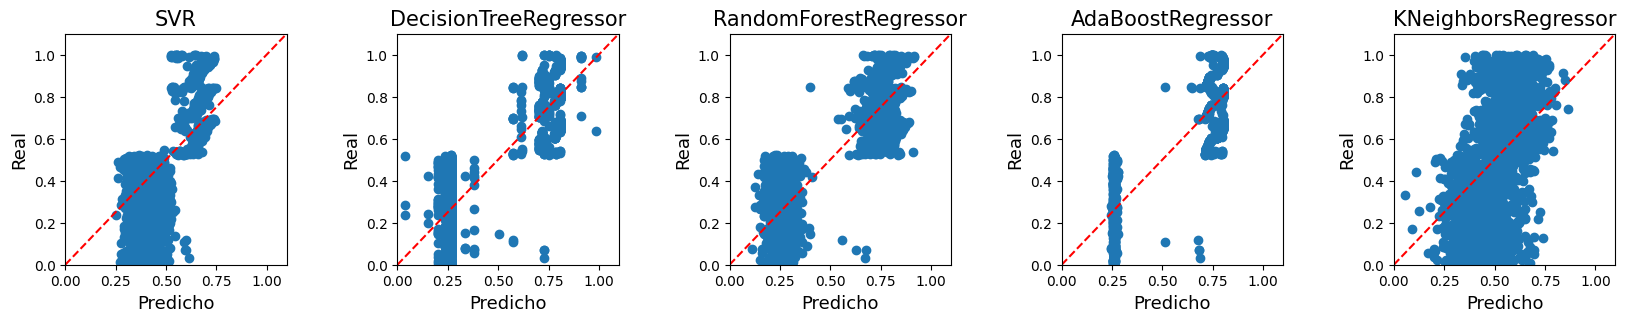

In [13]:
plot_results(test_results, y_test, '../docs/08_graph.eps')

### 09 - Etiquetado + timestamp labeling + quantile normalization + feature extraction (rfe)

In [ ]:
df_09 = df.copy(deep = True)

# Etiquetado de caracteristicas
category_list = [
    'source_country',
    'destination_country',
    'shipment_mode',
    'shipping_company'
]
for col in category_list:
    df_09[col] = LabelEncoder().fit_transform(df_09[col])

# Conversión de tiempo a categorias
df_09['send_timestamp'] = pd.to_datetime(df_09['send_timestamp'])
df_09["year"] =         df_09["send_timestamp"].dt.year
df_09["month"] =        df_09["send_timestamp"].dt.month
df_09["day"] =          df_09["send_timestamp"].dt.day
df_09["dayofweek"] =    df_09["send_timestamp"].dt.day_of_week
df_09["dayofyear"] =    df_09["send_timestamp"].dt.day_of_year
df_09["hour"] =         df_09["send_timestamp"].dt.hour
df_09["minute"] =       df_09["send_timestamp"].dt.minute
df_09.drop(columns="send_timestamp", inplace=True)

# Normalizado de variables numéricas por Quantile
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges',
    'shipping_time'
]
for col in numerical_list:
    df_09[col] = QuantileTransformer().fit_transform(df_09[[col]])


# Extracción de características por Recursive Feature Elimination
rfe_selector = RFE(
    estimator = RandomForestRegressor(),
    n_features_to_select = 5,
    step = 1
)
X = df_09.drop(columns=['shipping_time'])
y = df_09['shipping_time']
rfe_selector.fit(X, y)

selected_features = []
for i, feature in enumerate(rfe_selector.support_):
    if feature:
        selected_features.append(X.columns[i])
selected_features.append('shipping_time')

df_09 = df_09.filter(selected_features)

display(df_09)

In [ ]:
X = df_09.drop(columns=['shipping_time'])
y = df_09['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
train_results = train_models(X_train, y_train, model_list)

test_results = predict_models(X_test, y_test, train_results)

results = results_to_dataframe(train_results, test_results)

results.to_latex('../docs/tables/09_table.tex', index = False)

display(results)

In [ ]:
plot_results(test_results, y_test, '../docs/09_graph.eps')

### 10 - Onehot Encoding + timestamp + quantile normalization

In [ ]:
df_10 = df.copy(deep = True)

# Conversión de tiempo a categorias
df_10['send_timestamp'] = pd.to_datetime(df_10['send_timestamp'])
df_10["year"] =         df_10["send_timestamp"].dt.year
df_10["month"] =        df_10["send_timestamp"].dt.month
df_10["day"] =          df_10["send_timestamp"].dt.day
df_10["dayofweek"] =    df_10["send_timestamp"].dt.day_of_week
df_10["dayofyear"] =    df_10["send_timestamp"].dt.day_of_year
df_10["hour"] =         df_10["send_timestamp"].dt.hour
df_10["minute"] =       df_10["send_timestamp"].dt.minute
df_10.drop(columns="send_timestamp", inplace=True)

# Onehot encoding
df_10 = pd.get_dummies(df_10, dtype=int)

# Normalizado de variables numéricas por Quantile
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges'
]
for col in numerical_list:
    df_10[col] = QuantileTransformer().fit_transform(df_10[[col]])


time_scaler = QuantileTransformer()
df_10['shipping_time'] = time_scaler.fit_transform(df_10[['shipping_time']])


display(df_10)

In [ ]:
X = df_10.drop(columns=['shipping_time'])
y = df_10['shipping_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
train_results = train_models(X_train, y_train, model_list)

test_results = predict_models(X_test, y_test, train_results)

results = results_to_dataframe(train_results, test_results)

results.to_latex('../docs/tables/10_table.tex', index = False)

display(results)

In [ ]:
plot_results(test_results, y_test, '../docs/10_graph.eps')

## Predicción de fichero de tests

In [ ]:
test_df = pd.read_csv('../data/input/test_2.csv')

test_df.drop(
    columns = [
        'Unnamed: 0',       # Índice sin uso
        'shipment_id',      # ID aleatorio sin significancia
        'pick_up_point',    # Toma un único valor
        'drop_off_point',   # Toma un único valor
        'selected'          # Toma un único valor
    ],
    inplace = True
)

test_df['send_timestamp'] = pd.to_datetime(test_df['send_timestamp'])
test_df["year"] =         test_df["send_timestamp"].dt.year
test_df["month"] =        test_df["send_timestamp"].dt.month
test_df["day"] =          test_df["send_timestamp"].dt.day
test_df["dayofweek"] =    test_df["send_timestamp"].dt.day_of_week
test_df["dayofyear"] =    test_df["send_timestamp"].dt.day_of_year
test_df["hour"] =         test_df["send_timestamp"].dt.hour
test_df["minute"] =       test_df["send_timestamp"].dt.minute
test_df.drop(columns="send_timestamp", inplace=True)

# Onehot encoding
test_df = pd.get_dummies(test_df, dtype=int)

# Normalizado de variables numéricas por Quantile
numerical_list = [
    'freight_cost',
    'gross_weight',
    'shipment_charges'
]
for col in numerical_list:
    test_df[col] = QuantileTransformer().fit_transform(test_df[[col]])

display(test_df)

In [ ]:
best_regressor = train_results['DecisionTreeRegressor']['model']

prediction = best_regressor.predict(test_df)

In [ ]:
submission = pd.read_csv('../data/input/submission_2.csv')

submission['shipping_time'] = time_scaler.inverse_transform([[val] for val in prediction])[:,0]

submission.to_csv('../data/output/submission_2.csv', index=False)